In [ ]:
#@title **Downloading Dependencies**
%%capture
!pip install pennylane
!pip install hierarqcal
!pin install jax

!pip install numpy
!pip install tabulate

In [ ]:
#@title **Warning Filter**
import warnings
warnings.filterwarnings("ignore", message="PennyLane is currently not compatible with versions of JAX > 0.4.28. You have version 0.5.2 installed.")

In [ ]:
#@title **Loading the Data for the Electronic Hamiltonian ($HeH^+$ Molecule)**

import jax
from jax import numpy as np
import pennylane as qml
from tabulate import tabulate

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

# Load the data for HeH^+ molecule
dataset = qml.data.load('qchem', molname="HeH+")[0]

# Create the hamiltonian and determine the number of qubits we will need
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

print("Number of qubits:", qubits)
print("The Hamiltonian is given by:", H)

Number of qubits: 4
The Hamiltonian is given by: -1.5458724243288817 * I(0) + 0.7582840346680491 * Z(0) + 0.7582840346680491 * Z(1) + 0.23577187542980704 * (Z(0) @ Z(1)) + 0.05258434874916604 * (Y(0) @ Z(1) @ Y(2)) + 0.04324479694907271 * (Y(0) @ Y(2)) + 0.05258434874916604 * (X(0) @ Z(1) @ X(2)) + 0.04324479694907271 * (X(0) @ X(2)) + 0.05258434874916603 * (Y(1) @ Z(2) @ Y(3)) + 0.04324479694907271 * (Z(0) @ Y(1) @ Z(2) @ Y(3)) + 0.05258434874916603 * (X(1) @ Z(2) @ X(3)) + 0.04324479694907271 * (Z(0) @ X(1) @ Z(2) @ X(3)) + 0.03633593176600333 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.03633593176600333 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.03633593176600333 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.03633593176600333 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.191995644071161 * Z(2) + 0.1286780507371525 * (Z(0) @ Z(2)) + 0.191995644071161 * Z(3) + 0.16501398250315585 * (Z(0) @ Z(3)) + -0.009339551914671998 * (Y(0) @ Z(1) @ Y(2) @ Z(3)) + -0.009339551914671998 * (X(0) @ Z(1) @ X(2) @ Z(3)) + 0.16501398250315585 *

In [ ]:
#@title **Defining PennyLane's Lightning Qubit Simulator Device**

dev = qml.device("lightning.qubit", wires=qubits)

In [ ]:
#@title **Implementing Given's Rotation and Vector Representation of the Hartree-Fock State**
# Define number of electrons and the qubits for the Hartree-Fock state
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)

# Display the Hartree-Fock state
print("Hartree-Fock (HF) State:")
print(f"Number of electrons: {electrons}")
print(f"Number of qubits: {qubits}")
print(f"HF State Vector: {hf}")

Hartree-Fock (HF) State:
Number of electrons: 2
Number of qubits: 4
HF State Vector: [1 1 0 0]


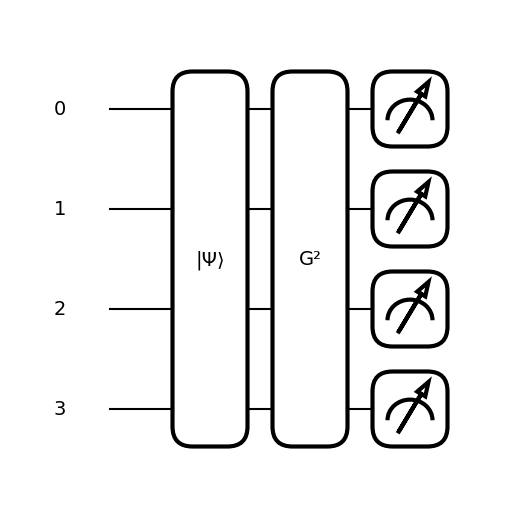

In [ ]:
#@title **Quantum Circuit Definition for Molecular Hamiltonian Expectation Calculation**

#@markdown - **DoubleExcitation(param, wires=[0, 1, 2, 3])**: This gate applies a two-particle excitation (or double excitation) to the qubits, where param is a parameter controlling the strength or magnitude of the excitation.
#@markdown - When **param = 0**, the DoubleExcitation gate will not alter the qubits at all, leaving them in their initial state.
#@markdown - When **param = 1**, it applies the full transformation, which might represent a certain angle of rotation or a specific quantum operation.

@qml.qnode(dev, interface="jax")
def circuit(param, wires):

    # initializes the 4-qubit register
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

    # return the expectation value of our molecular Hamiltonian prepared by the ciruit
    return qml.expval(H)

fig, ax = qml.draw_mpl(circuit)(param=0.5, wires=[0, 1, 2, 3])

In [ ]:
#@title **Energy Expectation Calculation for Given Quantum State**
# Initialise a quantum state and calculate the expectation value of the Hamiltonian H for that state
@qml.qnode(dev)
def exp_energy(state):
  qml.BasisState(np.array(state), wires=range(num_wires))
  return qml.expval(H)

num_wires = qubits
exp_energy(hf)
print("Qubits:", num_wires)
print("Energy Expectation:", exp_energy(hf))

Qubits: 4
Energy Expectation: -2.8419359554488315


In [ ]:
#@title **Ansatz Circuit for Candidate Ground State Preparation**
# build the circuit that prepares the candidate ground state
# params are the parameters of the DEG
def ansatz(params):
  # modify the hf-state, which acts on all the wires
  qml.BasisState(hf, wires=range(num_wires))

  # act with the 1st DEG, 1st element in the list params and acts on wires 0,1,2,3
  # --> since it takes the electons from the lowest energy level to the intermediate energy level
  qml.DoubleExcitation(params[0], wires=[0,1,2,3])

# defines a quantum circuit to prepare a candidate ground state by modifying the Hartree-Fock state and applying the Double Excitation Gate (DEG) parameterized by params

In [ ]:
#@title **Cost Function for Ground State Energy Optimization**
@qml.qnode(dev)
def cost_function(params): # cost function
  ansatz(params) # prepare candidate ground state
  return qml.expval(H) # return the expectation value of the hamiltonian

# compute the expectation value of the Hamiltonian H for a candidate ground state prepared by the ansatz, with the goal of optimizing the energy
print("Expectation Value of the Hamiltonian H:", cost_function([0.1]))

Expectation Value of the Hamiltonian H: -2.8507879499010267


In [ ]:
#@title **SPSA for Ground State Energy**

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

# Energy tracking
energy = [cost_function(theta)]
angle = [theta]
max_iterations = 20

# Define optimizer and initialization
opt = qml.SPSAOptimizer(maxiter=max_iterations)
theta = qml.numpy.array([0.0], requires_grad=True)  # initial angle

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_function, theta)
    curr_energy = cost_function(theta)

    energy.append(curr_energy)
    angle.append(theta)

    print(f"Step = {n}, Energy = {curr_energy:.8f} Ha")

print()
print(f"Final Ground Energy: {energy[-1]:.8f} Ha")
print(f"Final Angle Parameters: {theta[0]:.8f}")

Step = 0, Energy = -2.84295565 Ha
Step = 1, Energy = -2.84372354 Ha
Step = 2, Energy = -2.84433489 Ha
Step = 3, Energy = -2.84483942 Ha
Step = 4, Energy = -2.84526647 Ha
Step = 5, Energy = -2.84563479 Ha
Step = 6, Energy = -2.84595714 Ha
Step = 7, Energy = -2.84624256 Ha
Step = 8, Energy = -2.84649771 Ha
Step = 9, Energy = -2.84672764 Ha
Step = 10, Energy = -2.84693625 Ha
Step = 11, Energy = -2.84712663 Ha
Step = 12, Energy = -2.84730126 Ha
Step = 13, Energy = -2.84746217 Ha
Step = 14, Energy = -2.84761102 Ha
Step = 15, Energy = -2.84774920 Ha
Step = 16, Energy = -2.84787790 Ha
Step = 17, Energy = -2.84799811 Ha
Step = 18, Energy = -2.84811069 Ha
Step = 19, Energy = -2.84821637 Ha

Final Ground Energy: -2.84821637 Ha
Final Angle Parameters: 0.05503781


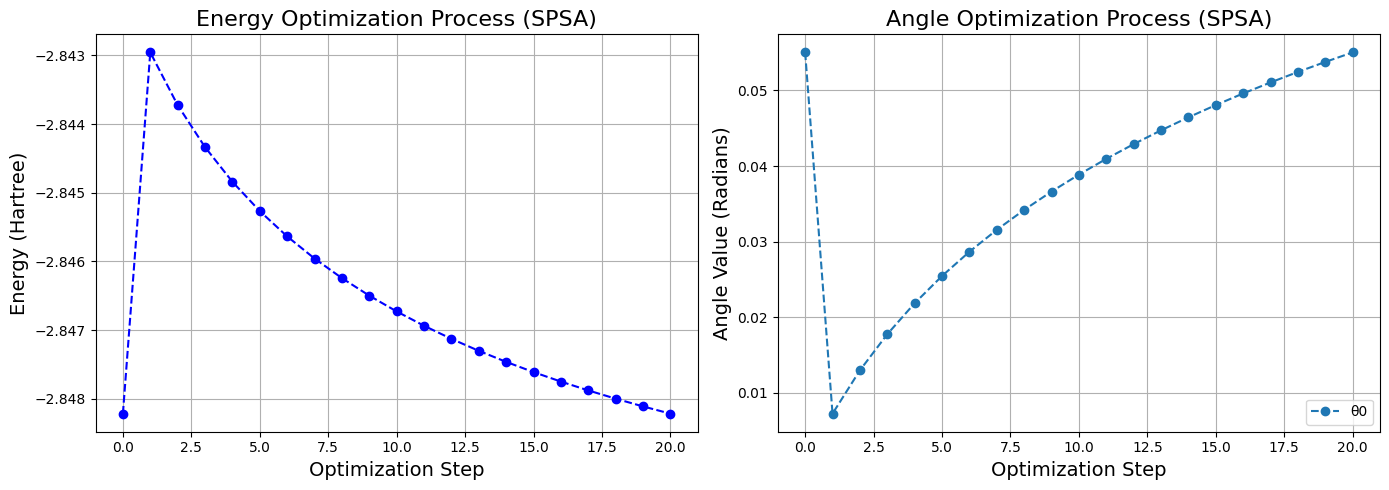

In [ ]:
#@title **Visualisation of the SPSA Convergence**

angle = np.array(angle)

# Plot energy values vs optimization steps
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(max_iterations + 1), energy, marker='o', linestyle='--', color='b')
plt.title('Energy Optimization Process (SPSA)', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.grid()

# Plot angles vs optimization steps
plt.subplot(1, 2, 2)
for i in range(angle.shape[1]):
    plt.plot(range(max_iterations + 1), angle[:, i], marker='o', linestyle='--', label=f'θ{i}')

plt.title('Angle Optimization Process (SPSA)', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Angle Value (Radians)', fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()